In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
%pip install -qq pandas matplotlib

In [ ]:
import time
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm

from sklearn.decomposition import FastICA


In [3]:
def logcosh_cuda(x):
    gx = torch.tanh(x)
    g_x = (1 - gx**2).mean(dim=1)
    return gx, g_x


ica_np = FastICA(
    n_components=None,
    random_state=0,
    algorithm="parallel",
    whiten=False,
    max_iter=20,
)
ica_torch = FastICA(
    n_components=None,
    random_state=0,
    algorithm="torch",
    whiten=False,
    max_iter=20,
    fun=logcosh_cuda,
)

In [ ]:
fix_features = product([1000, 10000, 100000], [1000])
fix_samples = product([1000], [10, 100])
params = list(fix_features) + list(fix_samples)


results = []
for n_samples, n_features in tqdm(params):
    print(n_samples, n_features)
    assert n_samples >= n_features
    # https://github.com/scikit-learn/scikit-learn/blob/56bbb5aeda441f3d5c129cd56c65bb1f09d7bb65/sklearn/decomposition/_fastica.py#L594-L600

    np.random.seed(0)
    X = np.random.randn(n_samples, n_features)
    start_torch = time.perf_counter()
    Y_torch = ica_torch.fit_transform(X)
    end_torch = time.perf_counter()

    start_np = time.perf_counter()
    Y_np = ica_np.fit_transform(X)
    end_np = time.perf_counter()

    diff = np.abs(Y_torch - Y_np)

    results.append(
        dict(
            n_samples=n_samples,
            n_features=n_features,
            torch=end_torch - start_torch,
            np=end_np - start_np,
            diff_max=diff.max(),
            diff_mean=diff.mean(),
            diff_std=diff.std(),
            diff_norm=np.linalg.norm(diff),
        )
    )

  0%|          | 0/5 [00:00<?, ?it/s]

1000 1000


100%|██████████| 20/20 [00:02<00:00,  9.09it/s]
/home/yuji96/scikit-learn/sklearn/decomposition/_fastica_torch.py:61: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
100%|██████████| 20/20 [00:26<00:00,  1.35s/it]
/home/yuji96/scikit-learn/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
 20%|██        | 1/5 [00:33<02:13, 33.46s/it]

10000 1000


100%|██████████| 20/20 [00:04<00:00,  4.01it/s]
/home/yuji96/scikit-learn/sklearn/decomposition/_fastica_torch.py:61: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
100%|██████████| 20/20 [00:24<00:00,  1.21s/it]
/home/yuji96/scikit-learn/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
 40%|████      | 2/5 [01:07<01:41, 33.96s/it]

100000 1000


100%|██████████| 20/20 [00:18<00:00,  1.10it/s]
/home/yuji96/scikit-learn/sklearn/decomposition/_fastica_torch.py:61: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
100%|██████████| 20/20 [01:10<00:00,  3.53s/it]
/home/yuji96/scikit-learn/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
 60%|██████    | 3/5 [02:48<02:08, 64.32s/it]

1000 10


100%|██████████| 20/20 [00:00<00:00, 179.51it/s]
/home/yuji96/scikit-learn/sklearn/decomposition/_fastica_torch.py:61: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
100%|██████████| 20/20 [00:00<00:00, 1263.19it/s]
/home/yuji96/scikit-learn/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
 80%|████████  | 4/5 [02:48<00:39, 39.00s/it]

1000 100


100%|██████████| 20/20 [00:00<00:00, 166.04it/s]
/home/yuji96/scikit-learn/sklearn/decomposition/_fastica_torch.py:61: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
100%|██████████| 20/20 [00:07<00:00,  2.60it/s]
/home/yuji96/scikit-learn/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
100%|██████████| 5/5 [02:57<00:00, 35.42s/it]


In [ ]:
df = pd.DataFrame(results)
df.to_csv("results.csv", index=False)
df

,n_samples,n_features,torch,np,diff_max,diff_mean,diff_std,diff_norm
0,1000,1000,4.472020,28.941629,9.233792e-10,5.429430e-11,4.955724e-11,7.351048e-08
1,10000,1000,7.785975,26.069959,2.269028e-08,3.021932e-09,2.298259e-09,1.200586e-05
2,100000,1000,22.554698,73.989594,5.175549e-08,6.411472e-09,4.869321e-09,8.050916e-05
3,1000,10,0.141223,0.024389,8.483325e-12,8.879595e-13,9.992628e-13,1.336786e-10
4,1000,100,0.298714,8.389551,1.980372e-09,2.521014e-10,1.986777e-10,1.015027e-07


Text(0, 0.5, 'time [s]')

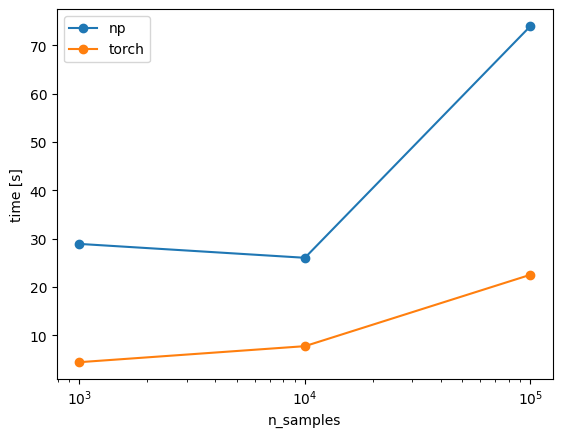

In [33]:
df_for_sample = df.query("n_features == 1000").sort_values("n_samples")
df_for_sample.plot(x="n_samples", y=["np", "torch"], logx=True, logy=False, marker="o")
plt.ylabel("time [s]")

Text(0, 0.5, 'time [s]')

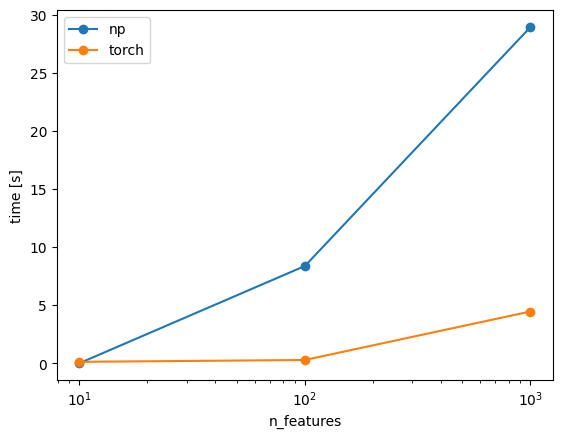

In [35]:
df_for_feature = df.query("n_samples == 1000").sort_values("n_features")
df_for_feature.plot(
    x="n_features", y=["np", "torch"], logx=True, logy=False, marker="o"
)
plt.ylabel("time [s]")